# Getting Started

We start by importing the library and configuring matplotlib to display the figures in a nice way.

In [2]:
import sys; sys.path.append('..')
import random
import pyzx as zx

%config InlineBackend.figure_format = 'svg'

Then we can create a new random Clifford circuit and visualise it.

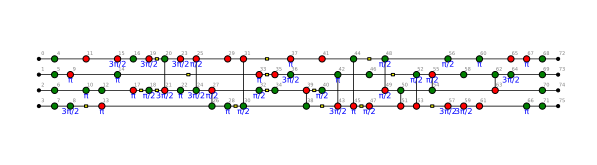

In [6]:
qubit_amount = 4
depth = 30
random.seed(17)
circ = zx.generate.cliffords(qubit_amount, depth)
zx.draw(circ,labels=True,h_edge_draw='box')

The green and red nodes represent Z- and X-phase gates respectively, the yellow boxes are Hadamard gates, and the vertical lines going between two different colored nodes are CNOT gates.

Internally this circuit is represented as a graph:

In [7]:
print(circ)
print("All edges: ", list(circ.edges()))
print("\nThe neighbours of a particular vertex: ", list(circ.neighbours(14)))


Graph(76 vertices, 84 edges)
All edges:  [(0, 4), (1, 5), (2, 6), (3, 7), (4, 11), (5, 9), (6, 10), (7, 8), (8, 13), (9, 14), (10, 12), (11, 15), (12, 17), (13, 26), (14, 33), (15, 16), (16, 19), (17, 18), (18, 21), (19, 20), (20, 21), (20, 23), (21, 22), (22, 24), (23, 25), (24, 25), (24, 27), (25, 29), (26, 27), (26, 28), (27, 32), (28, 30), (29, 31), (30, 31), (30, 38), (31, 37), (32, 34), (33, 35), (34, 39), (35, 36), (36, 42), (37, 41), (38, 39), (38, 43), (39, 40), (40, 49), (41, 44), (42, 43), (42, 46), (43, 45), (44, 45), (44, 48), (45, 47), (46, 52), (47, 51), (48, 49), (48, 56), (49, 50), (50, 51), (50, 54), (51, 53), (52, 53), (52, 55), (53, 57), (54, 55), (54, 63), (55, 58), (56, 60), (57, 59), (58, 62), (59, 61), (60, 65), (61, 66), (62, 63), (62, 64), (63, 70), (64, 69), (65, 67), (66, 71), (67, 68), (68, 72), (69, 73), (70, 74), (71, 75)]

The neighbours of a particular vertex:  [9, 33]


Using this graph representation we can use the rules of the ZX-calculus to simplify it:

In [8]:
g = circ.copy()
zx.clifford_simp(g)

spider_simp: 13. 9. 3. 1.  4 iterations
id_simp: 7.  1 iterations
spider_simp: 5. 3. 2.  3 iterations
pivot_simp: 5. 2.  2 iterations
lcomp_simp: 4.  1 iterations
id_simp: 1.  1 iterations
spider_simp: 1.  1 iterations
pivot_simp: 1. 1.  2 iterations


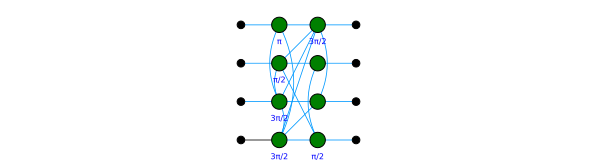

In [9]:
g.normalise() # Reposition nodes horizontally to look nicer
zx.draw(g)

The blue lines represent edges that have a Hadamard gate on them.

Let's try to see in a bit more detail what goes into rewriting this circuit.

In [10]:
from ipywidgets import widgets
from IPython.display import display, Markdown

from pyzx.simplify import clifford_iter

graph = circ.copy()
graphs = [zx.draw(graph)]
names = ["start"]
for gs, n in clifford_iter(graph):
    graphs.append(zx.draw(gs))
    names.append(n)
zx.drawing.pack_circuit_nf(gs,'grg')
graphs.append(zx.draw(gs))
names.append("reposition")

def plotter(rewrite):
    display(Markdown("Rewrite step: " + names[rewrite]))
    display(graphs[rewrite])

w = widgets.interactive(plotter, rewrite=(0,len(graphs)-1))
slider = w.children[0]
slider.layout.width = "{!s}px".format(min(800,50*len(graphs)))
output = w.children[-1]
output.layout.height = "{!s}px".format(200+qubit_amount*20)
slider.value = 0
w

interactive(children=(IntSlider(value=0, description='rewrite', layout=Layout(width='800px'), max=18), Output(…

As you can see, the first few steps are **spider fusion**, where adjacent red nodes and adjacent green nodes are fused together (and their phases added). The next step is to convert all red nodes to green nodes by changing regular edges to hadamard edges.

Now come the steps that do most of the work. These steps are a round of **pivots** followed by **local complementations** and then a round of pivots again. The local complementation rules looks for green nodes with a phase of $\frac\pi2$ or $\frac{3\pi}2$. By doing a local complementation on this node we can remove the node from the graph. This process is done until no more suitable candidates are found. A pivot consists of a series of three local complementations that is done on two neighbouring vertices that have a zero or $\pi$ phase. A pivot move allows us to remove these two nodes.

Finally we do a round of **identity** simplification which removes phaseless nodes that are connected to precisely two neighbours.

**Note**: Depending on the circuit that was generated, any of these steps might not have been done.

Even though this graph is a lot compacter than the one we started out with, it no longer looks like a circuit. To fix this we need to be clever.

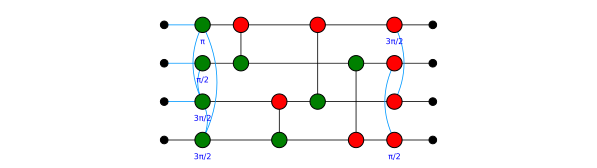

In [11]:
circ2 = g.copy()
circ2.normalise()
#circ2 = zx.extract.streaming_extract(circ2)
zx.extract.clifford_extract(circ2,1,2)
zx.draw(circ2)

To verify that this circuit is still equal to the original circuit, we can transform them into numpy tensors and compare these tensors for equality:

In [12]:
t1 = circ.to_tensor()
t2 = circ2.to_tensor()

zx.compare_tensors(t1,t2) # This checks whether t1 and t2 are equal up to some number: t1 == z*t2 for some complex number z

True

We can represent this circuit-like ZX-graph as an actual circuit using PyZX:

S*(3)
sdg q[3];
NOT(1)
x q[1];
Z(2)
z q[2];
HAD(3)
h q[3];
NOT(3)
x q[3];
Z(1)
z q[1];
XPhase(0,phase=3/2)
rx(1.5*pi) q[0];
NOT(2)
x q[2];
HAD(2)
h q[2];
S(2)
s q[2];
XPhase(0,phase=3/2)
rx(1.5*pi) q[0];
HAD(0)
h q[0];
HAD(2)
h q[2];
XPhase(2,phase=3/2)
rx(1.5*pi) q[2];
CNOT(0,2)
cx q[0], q[2];
Z(2)
z q[2];
XPhase(0,phase=3/2)
rx(1.5*pi) q[0];
S*(2)
sdg q[2];
XPhase(0,phase=1/2)
rx(0.5*pi) q[0];
CNOT(2,0)
cx q[2], q[0];
XPhase(2,phase=1/2)
rx(0.5*pi) q[2];
CNOT(3,2)
cx q[3], q[2];
Z(3)
z q[3];
HAD(3)
h q[3];
S(3)
s q[3];
CNOT(3,0)
cx q[3], q[0];
S(2)
s q[2];
HAD(1)
h q[1];
NOT(1)
x q[1];
HAD(2)
h q[2];
HAD(1)
h q[1];
S*(1)
sdg q[1];
HAD(0)
h q[0];
NOT(0)
x q[0];
CNOT(3,2)
cx q[3], q[2];
HAD(2)
h q[2];
S(2)
s q[2];
Z(1)
z q[1];
HAD(3)
h q[3];
XPhase(3,phase=3/2)
rx(1.5*pi) q[3];
CNOT(1,3)
cx q[1], q[3];
NOT(3)
x q[3];
CNOT(0,3)
cx q[0], q[3];
HAD(3)
h q[3];
XPhase(3,phase=1/2)
rx(0.5*pi) q[3];
HAD(0)
h q[0];
S(0)
s q[0];
XPhase(2,phase=1/2)
rx(0.5*pi) q[2];
CNOT(0,2)
cx q[0], q[2];
CNOT

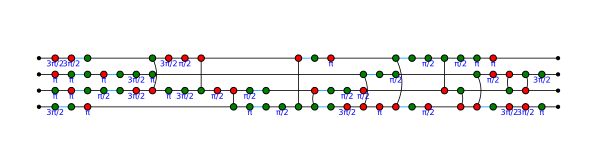

In [16]:
c = zx.Circuit.from_graph(circ)
for i in range(len(c.gates)):
    print(c.gates[i])
    try:
        print(c.gates[i].to_qasm())
    except:
        print("not supported")
zx.draw(c)

And we can represent this in one of several quantum circuit description languages, such as that of QUIPPER:

In [14]:
print(c.to_qasm())

TypeError: Gate CX(2,0) doesn't have a QASM description

Now lets try the same thing with a more complicated Clifford+T circuit.

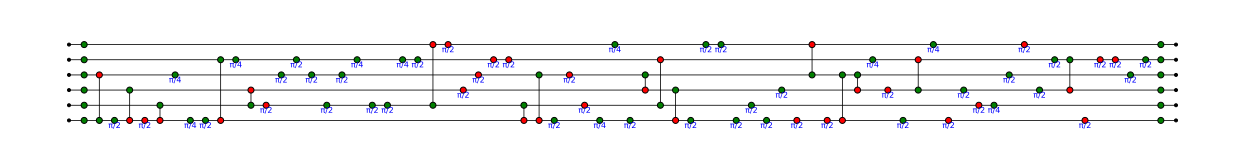

In [12]:
qubit_amount = 6
depth = 70
random.seed(1338)
circ = zx.generate.cliffordT(qubit_amount, depth,p_t=0.2)
zx.draw(circ,figsize=(17,2),h_edge_draw='box')

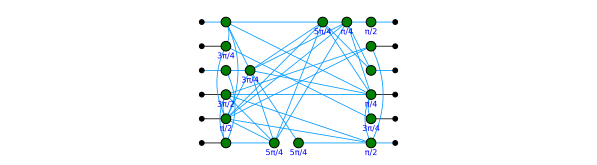

In [13]:
g = circ.copy()
zx.clifford_simp(g, quiet=True)
g.normalise()
zx.draw(g)

We use a different extraction procedure for this circuit. Instead of producing a ZX-graph as output we get a description as a circuit:

In [14]:
g2 = g.copy()
c = zx.extract.streaming_extract(g2)
print(c.stats())

Circuit  on 6 qubits with 55 gates.
        8 is the T-count
        47 Cliffords among which 
        27 2-qubit gates and 16 Hadamard gates.


We can convert this back into a PyZX-graph:

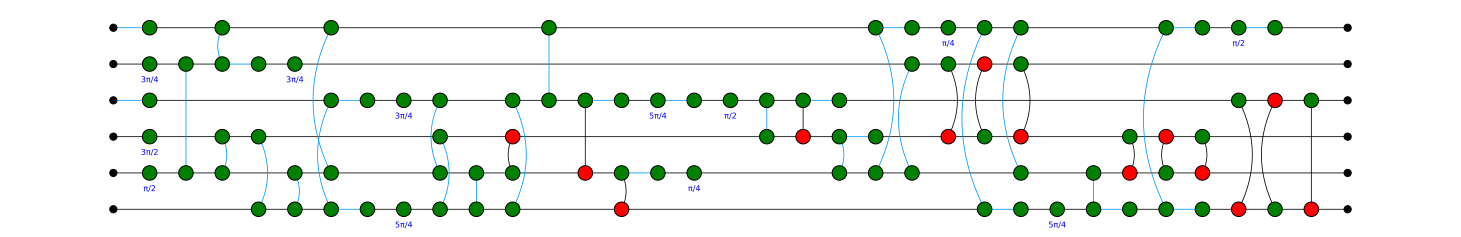

In [15]:
zx.draw(c.to_graph(), figsize=(20,3))

And verify that it is still equal to the original graph:

In [16]:
zx.compare_tensors(c.to_tensor(), circ.to_tensor())

True


    Now lets represent this circuit in the QASM circuit description language:

In [17]:
g = c.to_basic_gates().gates
for i in range(len(g)):
    print('{} -> {}'.format(g[i], g[i].to_qasm()))          

#     zx.circuit.QASMParser().parse(c.to_basic_gates().to_qasm())




ZPhase(1,phase=3/4) -> rz(2.356194490192345) q[1];
ZPhase(3,phase=3/2) -> rz(4.71238898038469) q[3];
ZPhase(4,phase=1/2) -> rz(1.5707963267948966) q[4];
HAD(2) -> h q[2];
HAD(0) -> h q[0];
CZ(1,4) -> cz q[1], q[4];
CZ(3,4) -> cz q[3], q[4];
CZ(3,5) -> cz q[3], q[5];
CZ(4,5) -> cz q[4], q[5];
CZ(5,2) -> cz q[5], q[2];
CZ(1,0) -> cz q[1], q[0];
CZ(4,0) -> cz q[4], q[0];
HAD(2) -> h q[2];
ZPhase(2,phase=3/4) -> rz(2.356194490192345) q[2];
HAD(5) -> h q[5];
ZPhase(5,phase=5/4) -> rz(3.9269908169872414) q[5];
HAD(1) -> h q[1];
ZPhase(1,phase=3/4) -> rz(2.356194490192345) q[1];
CZ(4,2) -> cz q[4], q[2];
CZ(3,5) -> cz q[3], q[5];
CZ(4,5) -> cz q[4], q[5];
CZ(2,5) -> cz q[2], q[5];
CZ(2,0) -> cz q[2], q[0];
CNOT(4,3) -> cx q[4], q[3];
CNOT(2,4) -> cx q[2], q[4];
HAD(2) -> h q[2];
ZPhase(2,phase=5/4) -> rz(3.9269908169872414) q[2];
HAD(2) -> h q[2];
ZPhase(2,phase=1/2) -> rz(1.5707963267948966) q[2];
CZ(3,2) -> cz q[3], q[2];
CNOT(2,3) -> cx q[2], q[3];
CNOT(4,5) -> cx q[4], q[5];
HAD(4) -> h q